# Load images with tf.data

- This tutorial provides a simple example of how to load an image dataset using [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data).

- The dataset used in this example is distributed as directories of images, with one class of image per directory.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()
tf.VERSION

'1.13.1'

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Download and inspect the dataset

### Retrieve the images

- Before you start any training, you'll need a set of images to teach the network about the new classes you wan to recognize. We've create an archive of creative-commons licensed flower photos to use initially.

In [3]:
import pathlib
data_root = tf.keras.utils.get_file('flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',untar=True)
data_root = pathlib.Path(data_root)
print(data_root)

/home/shioko/.keras/datasets/flower_photos


- After downloading 218MB, you should now have a copy of the flower photos available:

In [4]:
for item in data_root.iterdir():
    print(item)

/home/shioko/.keras/datasets/flower_photos/daisy
/home/shioko/.keras/datasets/flower_photos/dandelion
/home/shioko/.keras/datasets/flower_photos/LICENSE.txt
/home/shioko/.keras/datasets/flower_photos/tulips
/home/shioko/.keras/datasets/flower_photos/roses
/home/shioko/.keras/datasets/flower_photos/sunflowers


In [5]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [6]:
all_image_paths[:10]

['/home/shioko/.keras/datasets/flower_photos/roses/3494252600_29f26e3ff0_n.jpg',
 '/home/shioko/.keras/datasets/flower_photos/sunflowers/147804446_ef9244c8ce_m.jpg',
 '/home/shioko/.keras/datasets/flower_photos/roses/16449467833_d82aac5749_m.jpg',
 '/home/shioko/.keras/datasets/flower_photos/sunflowers/20753711039_0b11d24b50_n.jpg',
 '/home/shioko/.keras/datasets/flower_photos/daisy/1286274236_1d7ac84efb_n.jpg',
 '/home/shioko/.keras/datasets/flower_photos/tulips/13979098645_50b9eebc02_n.jpg',
 '/home/shioko/.keras/datasets/flower_photos/tulips/4418204816_018375acd0_m.jpg',
 '/home/shioko/.keras/datasets/flower_photos/sunflowers/6140693467_211a135b6d.jpg',
 '/home/shioko/.keras/datasets/flower_photos/daisy/3848258315_ed2fde4fb4.jpg',
 '/home/shioko/.keras/datasets/flower_photos/daisy/6950173662_5e9473003e_n.jpg']

### Inspect the images

- Now let's have a quick look at a couple of the images, so we know what we're dealing with:

In [7]:
attributions = (data_root/"LICENSE.txt").read_text(encoding='utf8').splitlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [8]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    image_rel = str(image_rel).replace('\\', '/')
    return "Image (CC 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1]) 

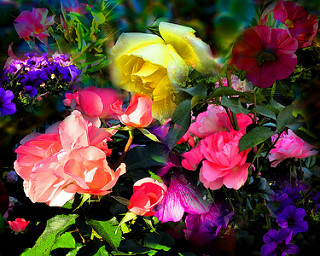

Image (CC 2.0)  by brillianthues



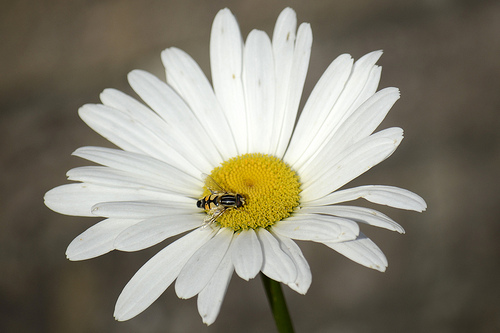

Image (CC 2.0)  by Alias 0591



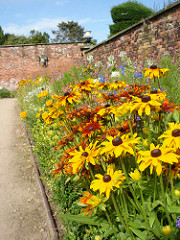

Image (CC 2.0)  by Hilverd Reker



In [9]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()

### Determine the label for each image

- List the available labels:

In [10]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

- Assign an index to each label:

In [11]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

- Create a list of every file, and its label index

In [12]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                   for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [2, 3, 2, 3, 0, 4, 4, 3, 0, 0]


### Load and format the images

- TensorFlow includes all the tools you need to load and process images:

In [13]:
img_path = all_image_paths[0]
img_path

'/home/shioko/.keras/datasets/flower_photos/roses/3494252600_29f26e3ff0_n.jpg'

- here is the raw data

In [14]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


- Decode it into an image tensor:

In [15]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(240, 320, 3)
<dtype: 'uint8'>


- Resize it for your model:

In [16]:
img_final = tf.image.resize_images(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


- Wrap up these in simple functions for later use.

In [17]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [192, 192])
    image /= 255.0 # normalize to [0, 1] range
    
    return image

In [18]:
def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [19]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
plt.show()
# print()

<Figure size 640x480 with 1 Axes>

## Build a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

### A dataset of images

- The easiest way to build a `tf.data.Dataset` is using the `from_tensor_slices` method.

- Slicing the array of strings results in dataset of strings:

In [20]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

- The `output_shapes` and `output_types` fields describe the content of each item in the dataset. In this case it is a set of scalar binary-strings

In [21]:
print('shape:', repr(path_ds.output_shapes))
print('type:', path_ds.output_types)
print()
print(path_ds)

shape: TensorShape([])
type: <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


- Now create a new dataset that loads and formats images on the fly by mapping `preprocess_image` over the dataset of paths.

In [22]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

Instructions for updating:
Colocations handled automatically by placer.


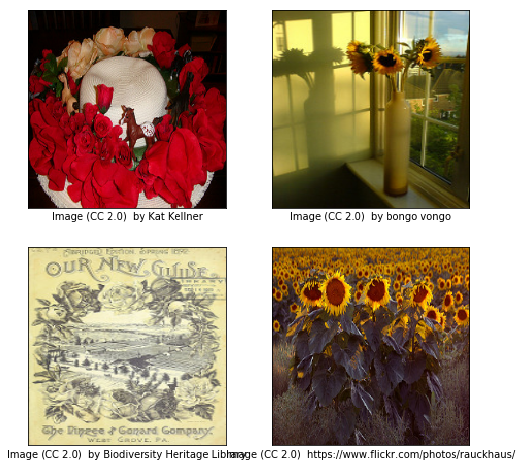

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2, 2, n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))

### A dataset of `(image, label)` pairs

- Using the same `from_tensor_slices` method we can build a dataset of labels

In [24]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [25]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

roses
sunflowers
roses
sunflowers
daisy
tulips
tulips
sunflowers
daisy
daisy


- Since the datasets are in the same order we can just zip them together to get a dataset of `(image, label)` pairs.

In [26]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

- The new dataset's `shapes` and `types` are tuples of shapes and types as well, describing each field:

In [27]:
print('image shape:', image_label_ds.output_shapes[0])
print('label shape:', image_label_ds.output_shapes[1])
print('types:', image_label_ds.output_types)
print()
print(image_label_ds)

image shape: (192, 192, 3)
label shape: ()
types: (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


- **Note**: When you have arrays like `all_image_labels` and `all_image_paths` and alternative to `tf.data.dataset.Dataset.zip` is to slice the pair of arrays.

In [28]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

### Basic methods for training

- To train a model with this dataset you will want the data:

    - To be well shuffled.
    
    - To be batched.
    
    - To repeat forever.
    
    - Batches to be available as soon as possible.
    
- These features can be easily added using `tf.data` api.

In [29]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

- There are a few things to note here:

    1. The order is important.
    
        - A `.shuffle` after a `repeat` would shuffle items across epoch boundaries (some items will be seen twice before others are not seen at all).
        
        - A `.shuffle` after a `.batch` would shuffle the order of the batches, but not shuffle the items across batches.
        
    2. We use a `buffer_size` the same size as the dataset for a full shuffle. Up to the dataset size, large values provide better randomization, but use more memory.
    
    3. The shuffle buffer is filled before any elements are pulled from it. So a large `buffer_size` may cause a delay when your `Dataset` is starting.
    
    4. The shuffled dataset doesn't report the end of dataset until the shuffle-buffer is completely empty. The `Dataset` is restarted by `.repeat`, causing another wait for the shuffle-buffer to be filled.
    
- This last point can be addressed by using the [`tf.data.Dataset.apply`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#apply) method with the fused [`tf.data.experimental.shuffle_and_repeat`](https://www.tensorflow.org/api_docs/python/tf/data/experimental/shuffle_and_repeat) function:

In [30]:
ds = image_label_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

### Pipe the dataset to a model

- Fetch a copy of MobileNet v2 from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

- This will be used for a simple transfer learning example.

- Set the MobileNet weights to be non-trainable:

In [31]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable = False

In [32]:
type(mobile_net)

tensorflow.python.keras.engine.training.Model

- This model expects its input to be normalized to the `[-1, 1]` range:

In [32]:
#help(keras_applications.mobilenet_v2.preprocess_input)

- So before the passing it to the MobileNet model, we need to convert the input from a range of `[0, 1]` to `[-1, 1]`.

In [33]:
def change_range(image, label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

- The MobileNet returns a `6x6` spatial grid of features for each image.

- Pass it a batch of images to see:

In [34]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [35]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


- So build a model wrapped around MobileNet, and use `tf.keras.layers.GlobalAveragePooling2D` to average over those space dimensions, before the output `tf.keras.layers.Dense` layer:

In [36]:
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(label_names))
])

- Now it produces outputs of the expected shape:

In [37]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print('max logit:', logit_batch.max())
print()

print('Shape:', logit_batch.shape)

min logit: -3.976835
max logit: 2.5830545

Shape: (32, 5)


- Compile the model to describe the training procedure:

In [38]:
model.compile(optimizer=tf.train.AdamOptimizer(),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

There are 2 trainable variables: The Dense `weights` and `bias`:

In [39]:
len(model.trainable_variables)

2

In [40]:
type(model)

tensorflow.python.keras.engine.sequential.Sequential

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


- Train the model.

- Normally you would specify the read number of steps per epoch, but for demonstration purposes only run 3 steps.

In [42]:
steps_per_epoch = tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [43]:
model.fit(keras_ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 24s 8s/step - loss: 7.2084 - acc: 0.3021


## Performance

- **Note**: This section just shows a couple of easy tricks that may help performance. For an in depth guide see [Input Pipeline Performance](https://www.tensorflow.org/guide/performance/datasets)

- The simple pipeline used above reads each file individually, on each epoch. This is fine for local training on CPU but may not be sufficient for GPU training, and is totally inappropriate for any sort of distributed training.

- To investigate, first build a simple function to check the performance of our datasets:

In [44]:
import time

def timeit(ds, batches=2*steps_per_epoch+1):
    overall_start = time.time()
    # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
    # before starting the timer
    it = iter(ds.take(batches+1))
    next(it)
    
    start = time.time()
    for i, (images, labels) in enumerate(it):
        if i%10 == 0:
            print('.', end='')
    print()
    end = time.time()
    
    duration = end-start
    print("{} batches: {} s".format(batches, duration))
    print('{:0.5} Images/s'.format(BATCH_SIZE*batches/duration))
    print('Total time: {}s'.format(end-overall_start))

- The performance of the current dataset is:

In [45]:
ds = image_label_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [46]:
timeit(ds)

........................
231.0 batches: 20.1450297832489 s
366.94 Images/s
Total time: 31.736018657684326s


### Cache

- Use [`tf.data.Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) to easily cache calculations across epochs. This is especially performant if the data fits in memory.

- Here the images are cached, after being pre-processed (decoded and resized):

In [47]:
ds = image_label_ds.cache()
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [48]:
timeit(ds)

........................
231.0 batches: 0.023936033248901367 s
3.0882e+05 Images/s
Total time: 8.693764686584473s


- If the data doesn't fit in memory, use a cache file:

In [49]:
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(1)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [50]:
timeit(ds)

........................
231.0 batches: 8.916306257247925 s
829.04 Images/s
Total time: 35.79410219192505s


- The cache file also has the advantage that it can be used to quickly restart the dataset without rebuilding the cache. Note how much faster it is the second time:

In [52]:
timeit(ds)

........................
231.0 batches: 6.784866571426392 s
1089.5 Images/s
Total time: 9.675141334533691s


### TFRecord File

#### Raw image data

- TFRecord files are a simple format to store a sequence of binary blobs. By packing multiple examples into the same file, TensorFlow is able to read multiple examples at once, which is especially important for performance when using a remote storage service such as GCS (Google Cloud Service).

- First, build a TFRecord file from the raw image data:

In [53]:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

- Next build a dataset that reads from the TFRecord file and decodes/reformats the images using the `preprocess_image` function we defined earlier.

In [54]:
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

- Zip that with the labels dataset we defined earlier, to get the expected `(image, label)` pairs.

In [55]:
ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [56]:
timeit(ds)

........................
231.0 batches: 15.897030353546143 s
464.99 Images/s
Total time: 22.694182634353638s


##### Serialized Tensors

- To save somee preprocessing to the TFRecord file, first make the dataset of the processed images, as before:

In [57]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = paths_ds.map(load_and_preprocess_image)
image_ds

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>

- Now instead of a dataset of `.jpeg` strings, this is a dataset of tensors.

- To serialize this to a TFRecord file you first convert the dataset of tensors to a dataset of strings.

In [58]:
ds = image_ds.map(tf.serialize_tensor)
ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [59]:
tfrec = tf.data.experimental.TFRecordWriter('serialized_images.tfrec')
tfrec.write(ds)

- With the preprocessing cached, data can be loaded from the TFRecord fiel quite efficiently. Just remember to de-serialized tensor before trying to use it.

In [64]:
RESTORE_TYPE = image_ds.output_types
RESTORE_SHAPE = image_ds.output_shapes

ds = tf.data.TFRecordDataset('serialized_images.tfrec')

def parse(x):
    result = tf.parse_tensor(x, out_type=RESTORE_TYPE)
    result = tf.reshape(result, RESTORE_SHAPE)
    return result

ds = ds.map(parse, num_parallel_calls=AUTOTUNE)
ds

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>

- Now, add the labels and apply the same standard operations as before:

In [65]:
ds = tf.data.Dataset.zip((ds, label_ds))
ds = ds.cache()
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [66]:
timeit(ds)

........................
231.0 batches: 2.0335657596588135 s
3635.0 Images/s
Total time: 25.138829708099365s
